Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\MSI GF66\PycharmProjects\AI_Machine\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Genre: Romance
Classification Accuracy: 0.670129432889421


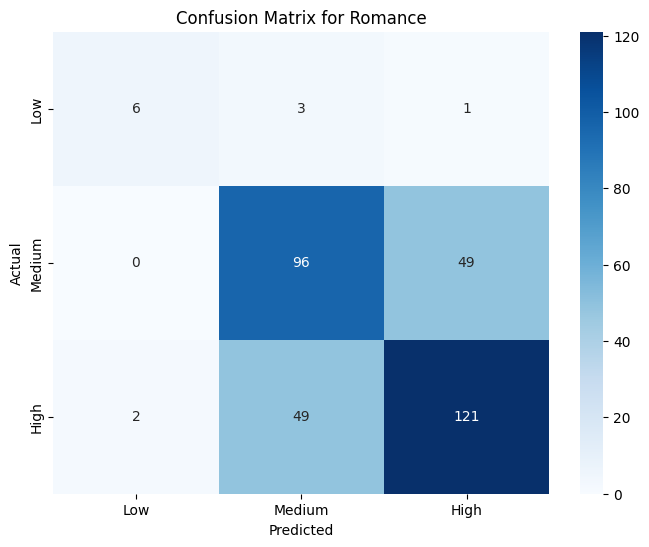

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Genre: Kids
Classification Accuracy: 0.6939651741293533


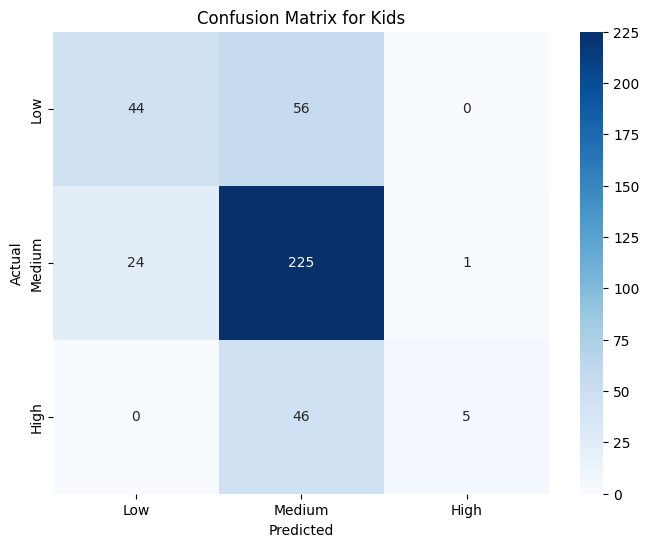

Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\MSI GF66\PycharmProjects\AI_Machine\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\MSI GF66\PycharmProjects\AI_Machine\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Genre: Josei
Classification Accuracy: 0.44305555555555554


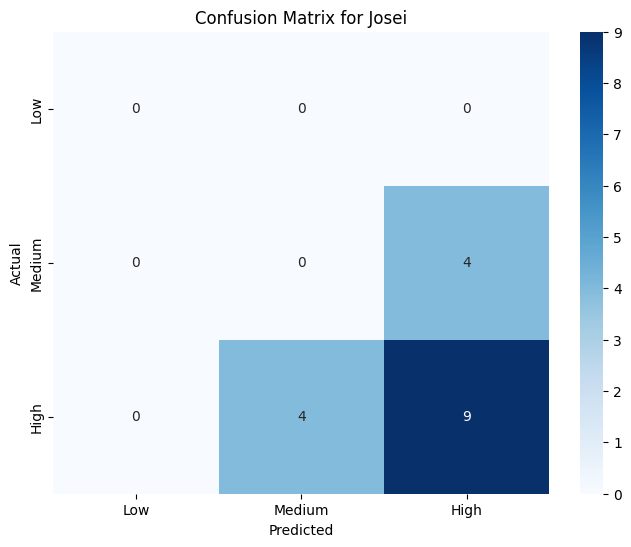

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Genre: Magic
Classification Accuracy: 0.6743922393641888


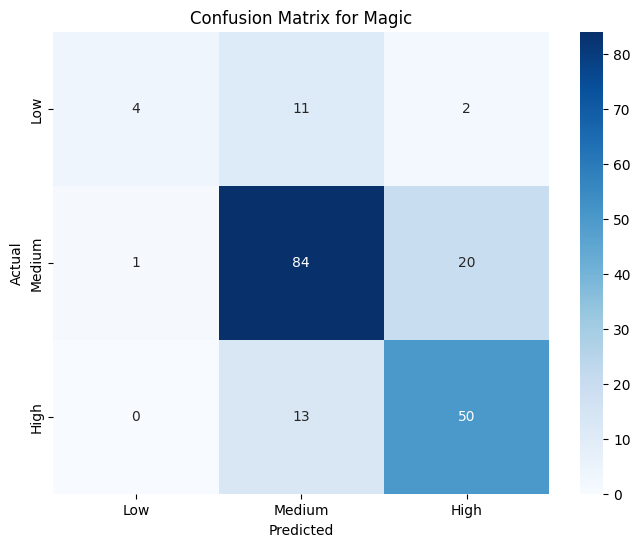

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Function to run Random Forest for specified genres
def run_random_forest_for_genres(genres):
    # Load the dataset
    data = pd.read_csv('AnimeList.csv')

    # Initialize storage for results
    results = {}

    for genre in genres:
        # Filter the specified genre
        genre_anime = data[data['genre'].str.contains(genre, na=False)].copy()

        if genre_anime.empty:
            print(f"No anime found for the genre: {genre}")
            continue

        # Label encoding for categorical columns
        label_encoder = LabelEncoder()
        categorical_cols = ['type', 'source']

        for col in categorical_cols:
            if col in genre_anime.columns:
                genre_anime.loc[:, col] = label_encoder.fit_transform(genre_anime[col].fillna('Unknown'))

        # Prepare target variable
        X = genre_anime.drop(columns=['anime_id', 'title', 'score', 'genre'], errors='ignore')
        y = genre_anime['score']

        # Categorize scores for classification ('Low', 'Medium', 'High')
        y_binned = pd.cut(y, bins=[0, 5, 7, 10], labels=["Low", "Medium", "High"], include_lowest=True)

        # Fill missing values
        if X.isnull().values.any() or y_binned.isnull().values.any():
            X = X.apply(lambda col: np.where(col.isna(), np.nanmean(col), col))
            y_binned = y_binned.fillna("Medium")

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.2, random_state=42)

        # Random Forest Classifier Model
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        # Best model
        best_rf_model = grid_search.best_estimator_

        # 10-Fold Cross Validation
        cv_scores = cross_val_score(best_rf_model, X, y_binned, cv=10)
        mean_cv_score = cv_scores.mean()

        # Predictions
        y_pred = best_rf_model.predict(X_test)

        # Evaluation
        print(f"Genre: {genre}")
        print(f"Classification Accuracy: {mean_cv_score}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])

        # Plot Confusion Matrix using Seaborn heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
        plt.title(f'Confusion Matrix for {genre}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

run_random_forest_for_genres(['Romance', 'Kids', 'Josei', 'Magic'])
